<a href="https://colab.research.google.com/github/edison0828/generative_ai/blob/main/HW11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📚 打造圖像生成 Web App (Prefect Illustrious XL v1.5)

**模型簡介：**

我使用由 **John6666** 創作的 **`prefect-illustrious-xl-v1.5-sdxl`** 模型。這是一個基於 Stable Diffusion XL (SDXL) 的微調模型，目標在生成具有日式動漫風的二次元人物圖像。
*(模型 civitai 連結：[https://civitai.com/models/1224788/prefect-illustrious-xl](https://civitai.com/models/1224788/prefect-illustrious-xl))*
*(模型 Hugging Face 連結：[https://huggingface.co/John6666/prefect-illustrious-xl-v15-sdxl](https://huggingface.co/John6666/prefect-illustrious-xl-v15-sdxl))*

---

**模型基礎設定建議 (來自模型作者)：**

以下是一些來自模型作者的推薦設定，本 WebUI 已將部分設定作為預設值或可選項：

*   **正面提示詞 (Positive Prompts) 推薦風格：**
    *   `masterpiece, best quality, amazing quality, absurdres`
*   **負面提示詞 (Negative Prompts) 推薦：**
    *   `bad quality, worst quality, worst detail, sketch, censored, watermark, signature, artist name`
*   **取樣器 (Samplers):**
    *   Euler A
*   **提示詞相關性 (CFG Scale):** 建議 5 - 6
    *(預設為 5.5，並提供滑桿調整)*
---



# 效果展示

### (1) 日常可愛風少女
###Prompt: masterpiece, best quality, anime style, 2d, 1girl, solo, upper body shot, cute expression, big innocent green eyes, short light brown bob cut with bangs, wearing a simple yellow t-shirt and denim overalls, bright plain background, clean lines
### Steps: 20
### Seed: 139494097

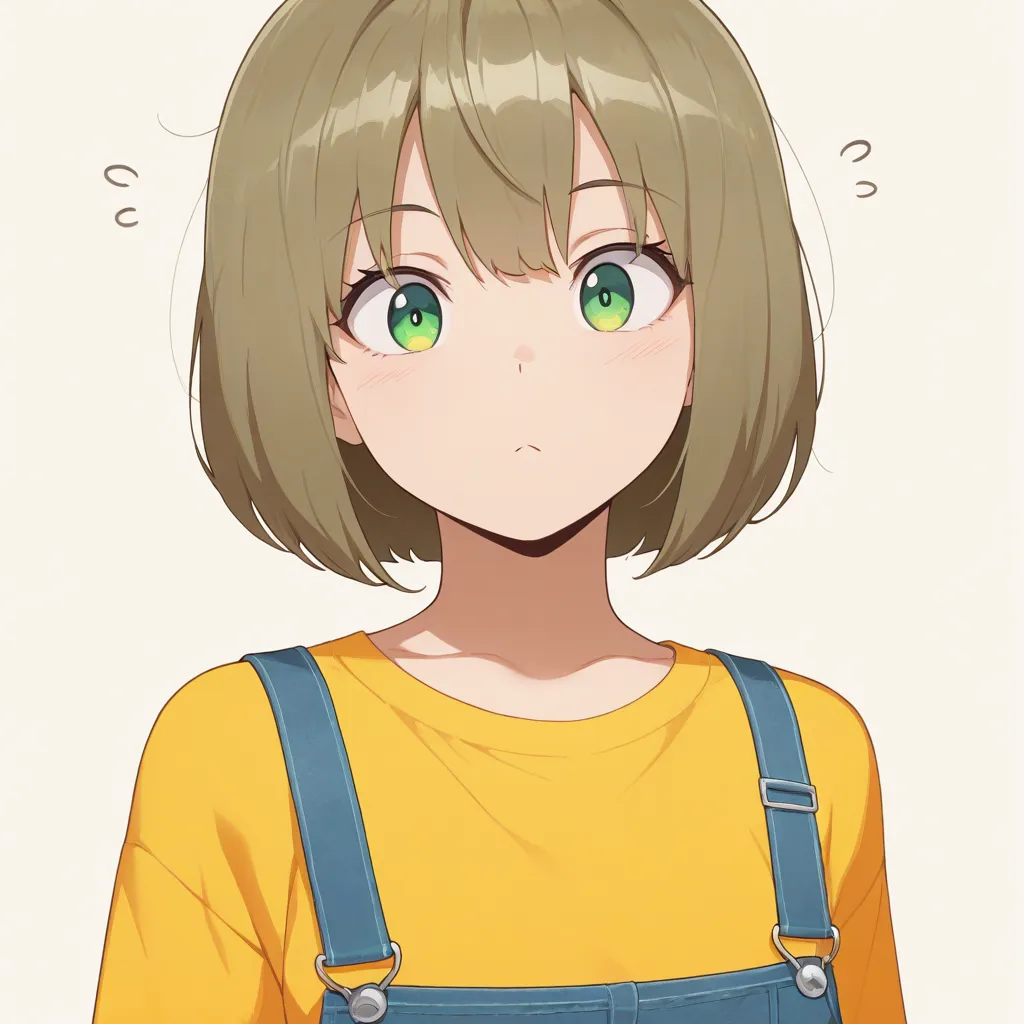

### (2) 風格:校園偶像風少女
###Prompt: masterpiece, best quality, anime style, illustration, vibrant colors, 1girl, solo, beautiful detailed eyes, sparkling pink eyes, long flowing blonde hair with twin tails, wearing a cute idol stage costume (frilly skirt, ribbons, star motifs), dynamic pose on a brightly lit stage, confetti falling, cheering crowd silhouette in background, looking at viewer with a bright smile
### Steps: 30
### Seed: 3574126467
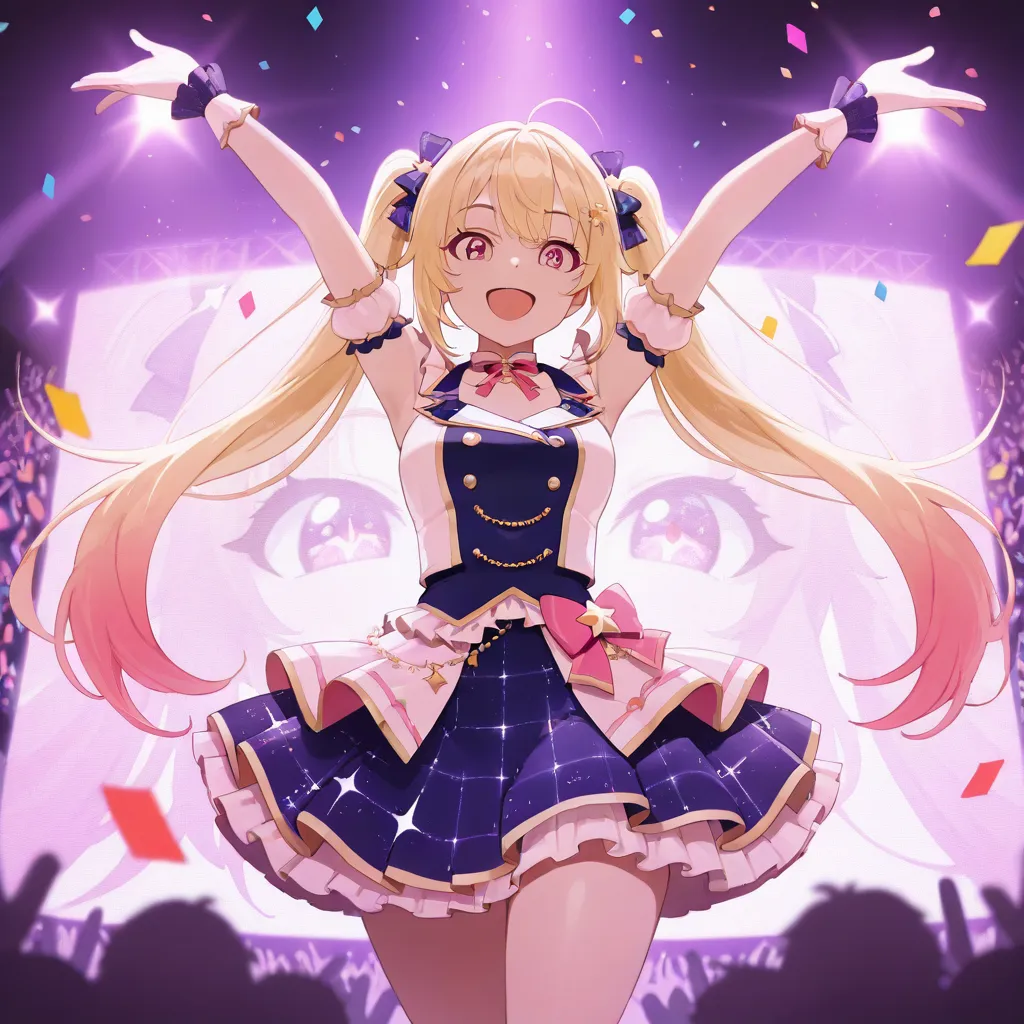

### (3) 風格:異世界狐妖少女
###Prompt: masterpiece, best quality, anime style, official art, 1girl, solo, mischievous smirk, golden fox eyes, long fluffy white fox ears and nine matching tails, fiery red hair tied in a high ponytail with a decorative bell, wearing a beautiful traditional red and gold kimono with intricate patterns, standing in a mystical bamboo forest, soft glowing lanterns hanging from branches
### Steps: 40
### Seed: 1104467970
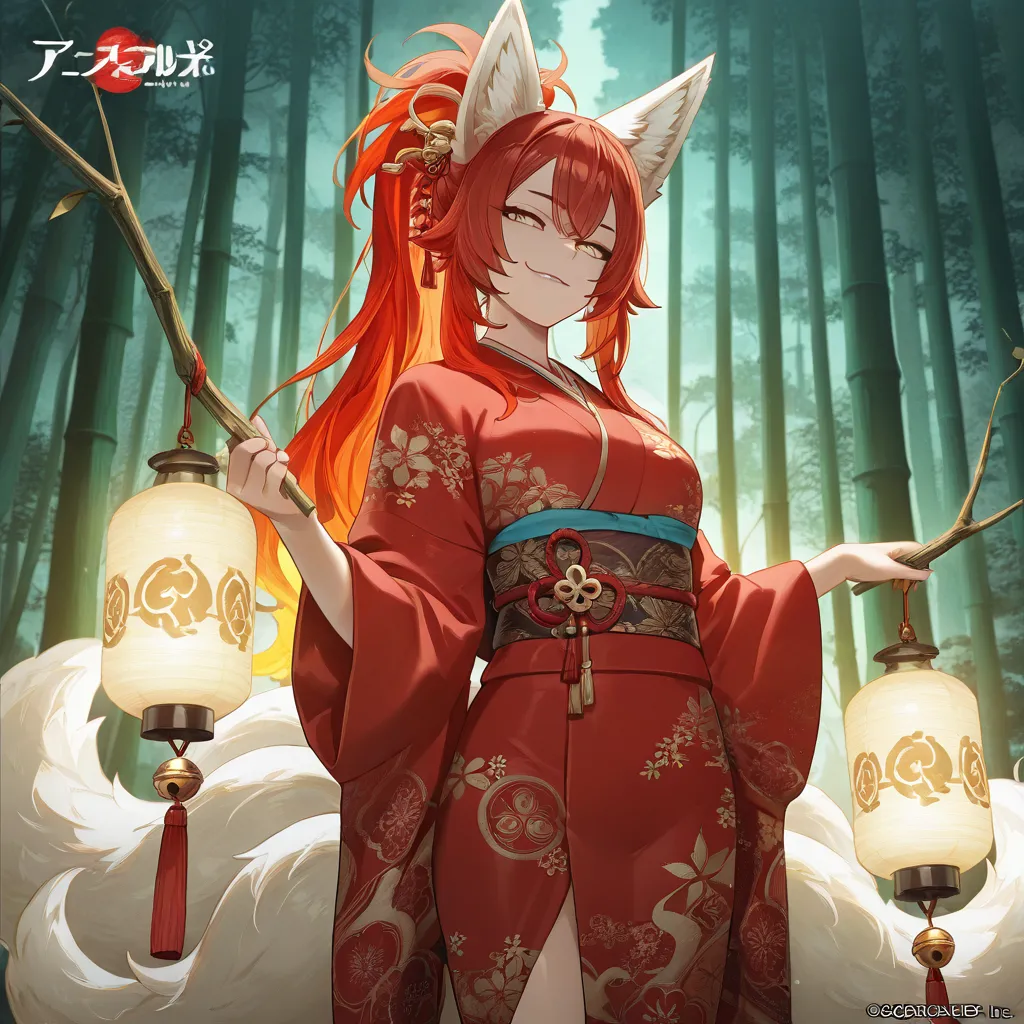

### (4) 風格:溫柔文學少女
###Prompt: masterpiece, best quality, anime style, illustration, soft colors, 1girl, solo, gentle smile, warm brown eyes, medium length chestnut brown hair with a side braid, wearing glasses and a cozy beige knitted sweater over a collared shirt, sitting by a sunlit window in a library, holding an open book, soft sunlight streaming in, peaceful atmosphere
### Steps: 50
### Seed: 461375255
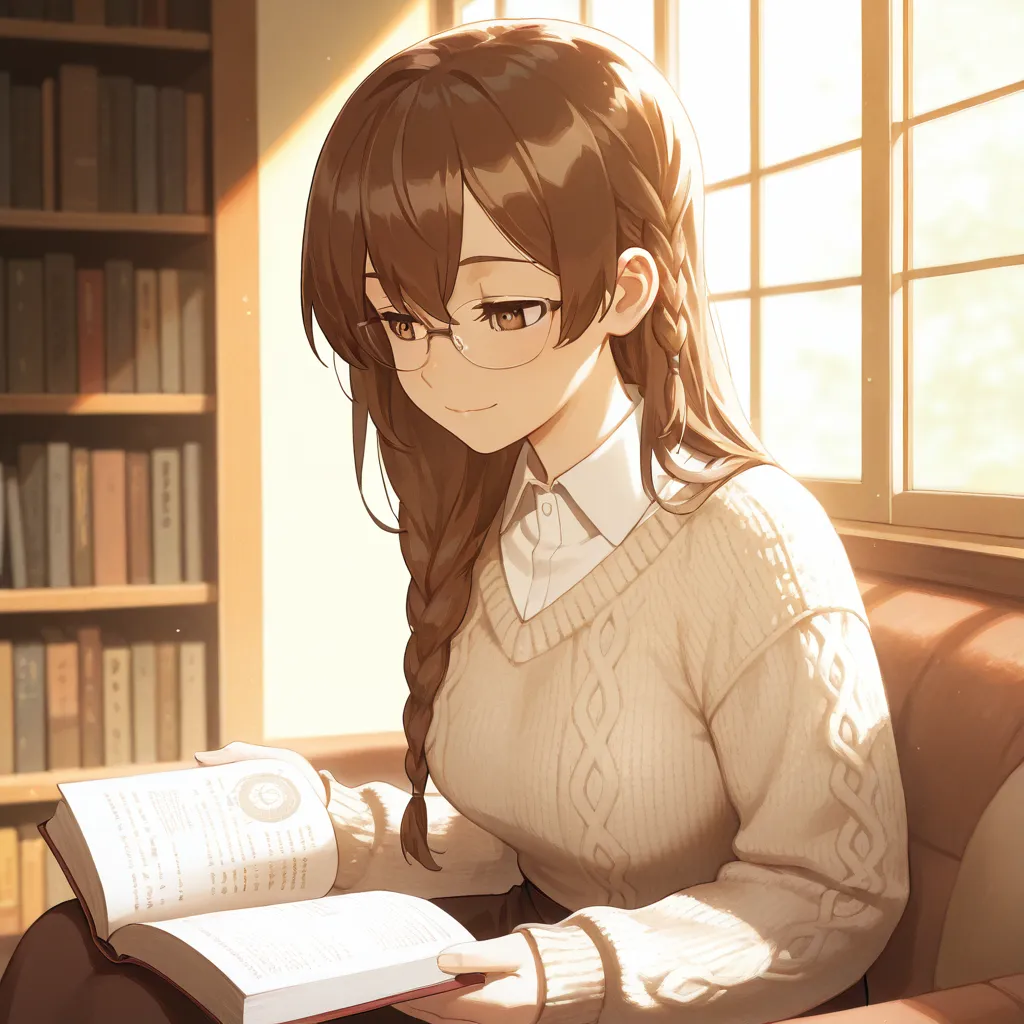

# 實作步驟

### 1. 安裝必要套件

In [ ]:
!pip install diffusers transformers accelerate safetensors huggingface_hub gradio --upgrade

In [ ]:
# from google.colab import userdata

# hf_token = userdata.get("HuggingFace")
# login(token=hf_token)

In [ ]:
from diffusers import DiffusionPipeline, EulerAncestralDiscreteScheduler # Import DiffusionPipeline and Schedulers
import torch
import gc
import matplotlib.pyplot as plt
import gradio as gr
import random

### 2. 指定並讀入模型

In [ ]:
model_name = "John6666/prefect-illustrious-xl-v15-sdxl"

注意有可能要停用 `use_safetensors=True`。

In [ ]:
print(f"Loading model: {model_name}...")
pipe = DiffusionPipeline.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    # use_safetensors=True
    # variant="fp16"
)
pipe.to("cuda")
print("Model loaded.")

scheduler_configs = {
    "Euler A": EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config),
}

### 3. 生成的函式

In [ ]:
def generate_images(prompt, use_recommended_positive, recommended_positive_text, use_negative, negative_text,
                    use_custom_seed, custom_seed, height, width, steps, guidance_scale, scheduler_name, num_images):

    print(f"\n--- Starting Generation ---")
    print(f"Prompt: {prompt}")
    print(f"Use Recommended Positive: {use_recommended_positive}")
    print(f"Use Negative: {use_negative}")
    print(f"Scheduler: {scheduler_name}")
    print(f"Steps: {steps}, CFG Scale: {guidance_scale}")
    print(f"Dimensions: {width}x{height}")
    print(f"Num Images: {num_images}")

    # Set the selected scheduler
    if scheduler_name in scheduler_configs:
        pipe.scheduler = scheduler_configs[scheduler_name]
        print(f"Using scheduler: {pipe.scheduler.__class__.__name__}")
    else:
        print(f"Warning: Scheduler '{scheduler_name}' not found, using default.")

    height = int(height)
    width = int(width)

    if height % 8 != 0 or width % 8 != 0:
        raise gr.Error("高度 (Height) 和寬度 (Width) 必須是 8 的倍數！")

    if use_custom_seed:
        base_seed = int(custom_seed)
    else:
        base_seed = random.randint(0, 2**32 - 1)
    print(f"Base Seed: {base_seed}")

    seeds = [base_seed + i for i in range(num_images)]

    final_prompt = prompt
    if use_recommended_positive and recommended_positive_text:
        final_prompt = prompt + ", " + recommended_positive_text
        print(f"Appended Positive: {recommended_positive_text}")

    final_negative = negative_text if use_negative and negative_text else None
    if final_negative:
         print(f"Using Negative Prompt: {final_negative}")

    # Generate images one by one to potentially save memory
    images = []
    for i in range(num_images):
        current_seed = seeds[i]
        print(f"Generating image {i+1}/{num_images} with seed {current_seed}...")
        generator = torch.Generator("cuda").manual_seed(current_seed)

        gc.collect()
        torch.cuda.empty_cache()

        try:
            with torch.no_grad():
                image = pipe(
                    prompt=final_prompt,
                    negative_prompt=final_negative,
                    height=height,
                    width=width,
                    num_inference_steps=steps,
                    guidance_scale=guidance_scale, # Use the provided guidance scale
                    generator=generator
                ).images[0]
            images.append(image)
            print(f"Image {i+1} generated.")
        except Exception as e:
            print(f"Error during image generation: {e}")
            raise gr.Error(f"生成過程中發生錯誤: {e}")

    print(f"--- Generation Complete ---")
    return images, f"使用的 Base Seed: {base_seed}, Seeds: {seeds}"

### 4. 打造 Gradio Web App

In [ ]:
# Defaults based on model recommendations
default_recommended_positive = "masterpiece, best quality, amazing quality, absurdres" # <<< Recommended positive
default_negative = "bad quality, worst quality, worst detail, sketch, censored, watermark, signature, artist name" # <<< Recommended negative

with gr.Blocks(css=".gradio-container {background-color: #F0F8FF; padding: 20px;} .gr-button {font-size: 18px; background: linear-gradient(to right, #4facfe, #00f2fe); color: white;}") as demo:
    gr.Markdown("""
    # 🎨 Prefect Illustrious XL v1.5 圖像生成器
    模型來源: John6666/prefect-illustrious-xl-v15-sdxl
    輸入提示詞 (prompt)、調整設定，生成你的專屬圖像！
    """)

    with gr.Row():
        with gr.Column(scale=6):
            prompt = gr.Textbox(label="主要提示詞 (Prompt)", placeholder="例如：Astronaut in a jungle, cold color palette, muted colors, detailed, 8k", lines=3)
            with gr.Row():
                use_recommended_positive = gr.Checkbox(label="附加推薦的正面提示詞 (Positive Prompt)", value=True)
                recommended_positive_text = gr.Textbox(label="推薦的正面提示詞內容", value=default_recommended_positive, lines=2)
            with gr.Row():
                use_negative = gr.Checkbox(label="使用負面提示詞 (Negative Prompt)", value=True)
                negative_text = gr.Textbox(label="負面提示詞內容", value=default_negative, lines=2)
            with gr.Row():
                 scheduler_name = gr.Dropdown(list(scheduler_configs.keys()), label="取樣器 (Scheduler/Sampler)", value="Euler A")
                 guidance_scale = gr.Slider(1.0, 10.0, value=5.5, step=0.5, label="提示詞相關性 (CFG Scale)")
            with gr.Row():
                use_custom_seed = gr.Checkbox(label="自訂隨機種子 (Seed)", value=False)
                custom_seed = gr.Number(label="指定 Seed (選填)", value=random.randint(0, 100000))
            with gr.Row():
                height = gr.Dropdown(["512", "768", "1024", "1280"], label="高度 (Height)", value="1024")
                width = gr.Dropdown(["512", "768", "1024", "1280"], label="寬度 (Width)", value="1024")
            with gr.Row():
                steps = gr.Slider(10, 60, value=30, step=1, label="生成步數 (Steps)")
                num_images = gr.Slider(1, 4, step=1, value=1, label="生成張數 (Number of Images)")
            generate_btn = gr.Button("🚀 開始生成！", variant="primary")

        with gr.Column(scale=6):
            gallery = gr.Gallery(label="生成結果 (Generated Images)", columns=2, object_fit="contain", height="auto")
            seed_info = gr.Label(label="使用的 Seed 資訊")


    generate_btn.click(
        fn=generate_images,
        inputs=[
            prompt, use_recommended_positive, recommended_positive_text, use_negative, negative_text,
            use_custom_seed, custom_seed, height, width, steps, guidance_scale, scheduler_name, num_images
        ],
        outputs=[gallery, seed_info]
    )

In [ ]:
demo.launch(share=True, debug=True)